In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *

In [19]:
path = untar_data(URLs.MNIST)
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/training'),
 PosixPath('/root/.fastai/data/mnist_png/testing')]

In [0]:
defaults.cmap = 'binary'

(PosixPath('/root/.fastai/data/mnist_png/training/3/31724.png'), None)

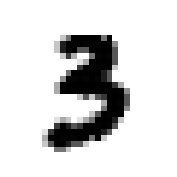

In [25]:
imglist = ImageList.from_folder(path,convert_mode = 'L')
imglist.items[0],imglist[0].show()

In [26]:
split = imglist.split_by_folder(train='training',valid = 'testing')
split

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Test: None

In [27]:
(path/'training').ls()

[PosixPath('/root/.fastai/data/mnist_png/training/3'),
 PosixPath('/root/.fastai/data/mnist_png/training/7'),
 PosixPath('/root/.fastai/data/mnist_png/training/0'),
 PosixPath('/root/.fastai/data/mnist_png/training/5'),
 PosixPath('/root/.fastai/data/mnist_png/training/2'),
 PosixPath('/root/.fastai/data/mnist_png/training/4'),
 PosixPath('/root/.fastai/data/mnist_png/training/6'),
 PosixPath('/root/.fastai/data/mnist_png/training/9'),
 PosixPath('/root/.fastai/data/mnist_png/training/8'),
 PosixPath('/root/.fastai/data/mnist_png/training/1')]

In [28]:
lbl = split.label_from_folder()
lbl

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
3,3,3,3,3
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
3,3,3,3,3
Path: /root/.fastai/data/mnist_png;

Test: None

In [0]:
tfms = ([*rand_pad(padding=2,size=28,mode='reflection')],[])

In [0]:
data = lbl.transform(tfms).databunch(bs=128).normalize()

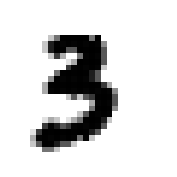

In [45]:
  data.train_ds[0][0].show()

In [0]:
def _plot(x,y,ax):
  data.train_ds[5][0].show(ax,y=data.train_ds[5][1])

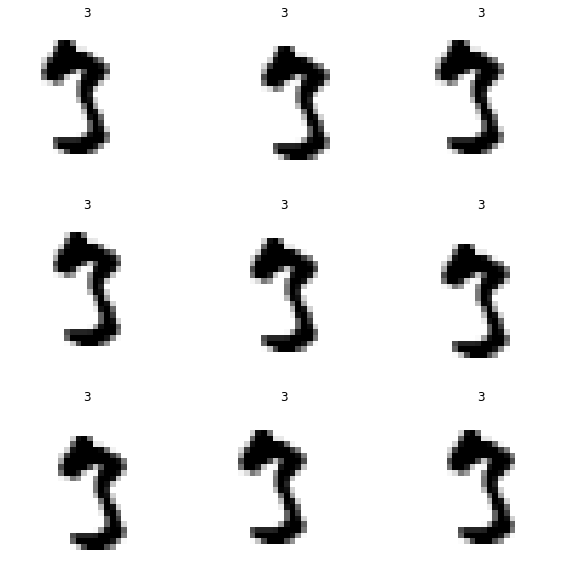

In [47]:
plot_multi(_plot,3,3,figsize=(10,10))

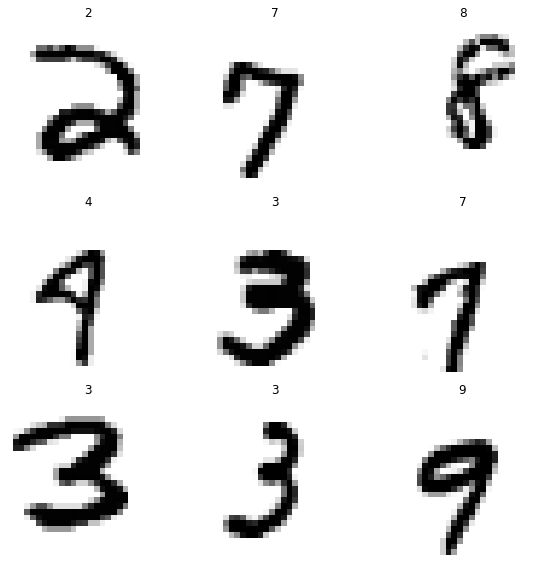

In [48]:
data.show_batch(3,figsize=(8,8))

In [0]:
def conv(n,m): return nn.Conv2d(n,m,kernel_size = 3,stride=2,padding=1)

In [0]:
model = nn.Sequential(
          conv(1,8), #14
          nn.BatchNorm2d(8),
          nn.ReLU(),
          conv(8,16), #7
          nn.BatchNorm2d(16),
          nn.ReLU(),
          conv(16,32), #4
          nn.BatchNorm2d(32),
          nn.ReLU(),
          conv(32,16), #2
          nn.BatchNorm2d(16),
          nn.ReLU(),
          conv(16,10), #1
          nn.BatchNorm2d(10),
          nn.Flatten()
)     

In [0]:
learn = Learner(data,model,loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


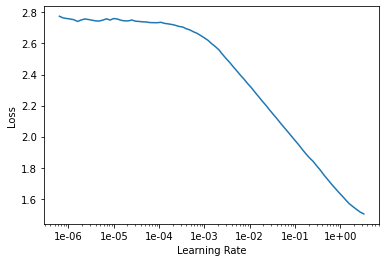

In [65]:
learn.lr_find()
learn.recorder.plot()

In [66]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.439146,0.284644,0.965700,00:34
1,0.151904,0.098057,0.978300,00:34
2,0.097303,0.059775,0.984600,00:34
3,0.071509,0.042874,0.988700,00:34
4,0.061283,0.038005,0.990000,00:34


In [0]:
def conv2(n,m) :
  return conv_layer(n,m,stride=2)

In [0]:
model = nn.Sequential(
        conv2(1,8),
        conv2(8,16),
        conv2(16,32),
        conv2(32,16),
        conv2(16,10),
        nn.Flatten()
)

In [0]:
learn = Learner(data,model,loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [78]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.547050,0.283192,0.956700,00:33
1,0.180007,0.098797,0.977300,00:33
2,0.108730,0.057310,0.985300,00:34
3,0.083268,0.044186,0.987700,00:33
4,0.075166,0.041162,0.988600,00:34


In [80]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [16, 7, 7]           1,152      True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
Conv2d               [32, 4, 4]           4,608      True      
___________________________________________________

In [0]:
class Resblock(nn.Module):
  def __init__(self,n):
    super().__init__()
    self.conv1 = conv_layer(n,n)
    self.conv2 = conv_layer(n,n)
  
  def forward(self,x):
    return x + self.conv2(conv1(x))
                

In [0]:
model = nn.Sequential(
        conv2(1,8),
        Resblock(8),
        conv2(8,16),
        Resblock(16),
        conv2(16,32),
        Resblock(32),
        conv2(32,16),
        Resblock(16),
        conv2(16,10),
        nn.Flatten()
        
)

In [0]:
def conv_and_res(n,m):
  return nn.Sequential(conv2(n,m),res_block(m))

In [0]:
model = nn.Sequential(
          conv_and_res(1,8),
          conv_and_res(8,16),
          conv_and_res(16,32),
          conv_and_res(32,16),
          conv2(16,10),
          nn.Flatten()
)

In [0]:
learn = Learner(data,model,loss_func=nn.CrossEntropyLoss(),metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


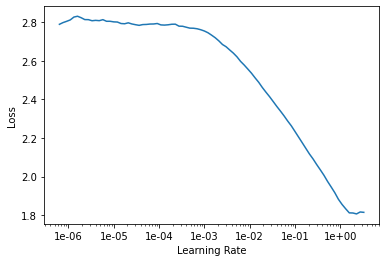

In [90]:
learn.lr_find()
learn.recorder.plot(end_lr = 100)


In [91]:
learn.fit_one_cycle(10,0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.154562,0.231591,0.930400,00:39
1,0.127872,0.084001,0.974400,00:39
2,0.112943,0.290094,0.898900,00:39
3,0.086006,0.067042,0.979500,00:39
4,0.072643,0.102396,0.966800,00:39
5,0.062461,0.127087,0.960000,00:39
6,0.044153,0.033486,0.989700,00:39
7,0.035923,0.023207,0.992200,00:39
8,0.025752,0.015289,0.994400,00:39
9,0.019518,0.014062,0.995000,00:39


In [92]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
___________________________________________________